In [1]:

import os
from datetime import datetime

import pandas as pd
import torch
from torch.utils.data import DataLoader

from datasets.SlideSeperatedCSVDataset import SlideSeperatedCSVDataset
from extractors.TemplateMatchExtractor import TemplateMatchExtractor, generate_dataset_from_slides
from labelers.GroundTruthLabeler import GroundTruthLabeler
from models.mlp import MLPBinaryClassifier
from models.resnet import Resnet18BinaryClassifier
from train import train_classifier
from utils import extract_features_from_dataset
from utils import plot_model_metrics
from utils import reduce_dataset, split_dataset


In [2]:
slides_root_dir = "data/whole-slides/gut"
labels_root_dir = "data/labels"
candidates_dataset_dir = "output/candidates"
model_output_dir = "output/models"
PretrainedModelClass = Resnet18BinaryClassifier
features_csv_file_name = f"{PretrainedModelClass.get_pretrained_model_name()}_{PretrainedModelClass.pretrained_output_size}_features.csv"
print(f"{PretrainedModelClass.get_pretrained_model_name()}: {PretrainedModelClass.pretrained_output_size} features")

Resnet18: 512 features


In [ ]:
ground_truth_labeler = GroundTruthLabeler(f"{labels_root_dir}/slide-annotations/all.json",
                                          f"{labels_root_dir}/patch-classifications.csv")
extractor = TemplateMatchExtractor(ground_truth_labeler)
generate_dataset_from_slides(slides_root_dir, extractor, candidates_dataset_dir)

Generating candidates dataset from 22 slides...


Extracting candidates from slide 522021:  58%|█████▊    | 285/490 [00:22<00:52,  3.88it/s]

In [4]:
extract_features_from_dataset(candidates_dataset_dir,
                              [Resnet18BinaryClassifier])

Device: cuda:0


Extracting feats from Resnet18: 100%|██████████| 1536/1536 [08:27<00:00,  3.03it/s]


In [5]:
def assign_categories(dataframe):
    q1, median, q3 = dataframe['n_gt_positive_regions'].quantile([0.25, 0.5, 0.75])

    def categorize_quartiles(n_annotations):
        if n_annotations <= q1:
            return "Low"
        elif q1 < n_annotations <= median:
            return "Medium"
        elif median < n_annotations <= q3:
            return "High"
        else:
            return "Very High"

    dataframe['category'] = dataframe['n_gt_positive_regions'].apply(lambda x: categorize_quartiles(x))
    return dataframe


def split_data(dataframe, train_portion=0.7):
    train_set = pd.DataFrame()
    test_set = pd.DataFrame()
    for category in dataframe['category'].unique():
        category_slides = dataframe[dataframe['category'] == category]
        train_samples = category_slides.sample(frac=train_portion)
        test_samples = category_slides.drop(train_samples.index)
        train_set = pd.concat([train_set, train_samples])
        test_set = pd.concat([test_set, test_samples])
    return train_set, test_set


slides_df = ground_truth_labeler.positive_regions_summary
slides_df = assign_categories(slides_df)
train_slides, test_slides = split_data(slides_df)
print("Train Slides")
train_slides

Train Slides


,slide_name,n_gt_positive_regions,category
1,593445,107,Very High
14,522934,182,Very High
20,593449,281,Very High
0,593435,104,Very High
2,593453,19,Medium
18,593454,22,Medium
4,593447,25,Medium
11,593444,31,Medium
17,593440,71,High
3,593437,94,High


In [6]:
print("Test Slides")
test_slides

Test Slides


,slide_name,n_gt_positive_regions,category
7,593436,170,Very High
9,593452,296,Very High
8,593434,27,Medium
10,593439,31,Medium
16,593438,92,High
15,522021,3,Low
19,593441,4,Low


In [7]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

batch_size = 4096
# dataset = SlideSeperatedImageDataset(candidates_dataset_dir, set(train_slides["slide_name"]))
dataset = SlideSeperatedCSVDataset(f"{candidates_dataset_dir}/{features_csv_file_name}",
                                   set(train_slides["slide_name"]))
dataset = reduce_dataset(dataset, discard_ratio=0.0)
train_dataset, validation_dataset = split_dataset(dataset, train_ratio=0.9)
# train_dataset = undersample_dataset(train_dataset)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
validation_loader = DataLoader(validation_dataset,
                               batch_size=batch_size,
                               shuffle=True, )

# model = Resnet18BinaryClassifier(hidden_layers=1, units_per_layer=2048,
#                       dropout=0.3, focal_alpha=0.9, focal_gamma=2.0)
model = MLPBinaryClassifier(in_features=PretrainedModelClass.pretrained_output_size, hidden_layers=2,
                            units_per_layer=PretrainedModelClass.pretrained_output_size,
                            dropout=0.3, focal_alpha=0.85, focal_gamma=4.0)

print(f"Dataset: {len(train_dataset):,} training, {len(validation_dataset):,} validation")


Device: cuda:0
Dataset: 85,362 training, 9,485 validation


In [8]:
print(model)

MLPBinaryClassifier(
  (model): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=512, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [9]:
print(f"Training starts {datetime.now().isoformat()}")

Training starts 2025-02-06T21:28:19.385456


In [10]:

model = model.to(device)
model, model_metrics = train_classifier(model, train_loader, validation_loader, device,
                                        start_learning_rate=0.000050,
                                        min_learning_rate=0.000025,
                                        lr_warmup_steps=20,
                                        max_epochs=30,
                                        checkpoint_every=1,
                                        eval_every=1)


Epoch 1 training: 100%|██████████| 21/21 [00:01<00:00, 11.07it/s]


Train: 1/30: lr: 0.000050000000 loss:0.0038492203401845125


Epoch 1 testing: 100%|██████████| 3/3 [00:00<00:00, 15.99it/s]


Test: 1/30: loss:0.002638390831028422, accuracy:0.9885242577218678, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, ece:0.011475742173691591, epoch:1


Epoch 2 training: 100%|██████████| 21/21 [00:01<00:00, 12.81it/s]


Train: 2/30: lr: 0.000050000000 loss:0.0026982529199726527


Epoch 2 testing: 100%|██████████| 3/3 [00:00<00:00, 17.44it/s]


Test: 2/30: loss:0.0024469352792948484, accuracy:0.9878185849486014, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, ece:0.012181414912144342, epoch:2


Epoch 3 training: 100%|██████████| 21/21 [00:01<00:00, 12.74it/s]


Train: 3/30: lr: 0.000050000000 loss:0.0023874404640602215


Epoch 3 testing: 100%|██████████| 3/3 [00:00<00:00, 17.15it/s]


Test: 3/30: loss:0.0021834796449790397, accuracy:0.9874657485619682, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, ece:0.012534251436591148, epoch:3


Epoch 4 training: 100%|██████████| 21/21 [00:01<00:00, 12.37it/s]


Train: 4/30: lr: 0.000050000000 loss:0.0021272316364394058


Epoch 4 testing: 100%|██████████| 3/3 [00:00<00:00, 14.76it/s]


Test: 4/30: loss:0.0018101154128089547, accuracy:0.9881714213352346, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, ece:0.011828578698138395, epoch:4


Epoch 5 training: 100%|██████████| 21/21 [00:01<00:00, 11.88it/s]


Train: 5/30: lr: 0.000050000000 loss:0.0019412467843808589


Epoch 5 testing: 100%|██████████| 3/3 [00:00<00:00, 15.99it/s]


Test: 5/30: loss:0.0017117911872143547, accuracy:0.9851597871753351, precision:0.22222222222222224, recall:0.09622782446311857, f1:0.13292929292929292, mcc:0.13865597557639897, ece:0.014840212961037954, epoch:5


Epoch 6 training: 100%|██████████| 21/21 [00:01<00:00, 11.89it/s]


Train: 6/30: lr: 0.000050000000 loss:0.0018414138273025553


Epoch 6 testing: 100%|██████████| 3/3 [00:00<00:00, 14.76it/s]


Test: 6/30: loss:0.001662223250605166, accuracy:0.9727888626055362, precision:0.15083749754285772, recall:0.3125960327637796, f1:0.20180944303081705, mcc:0.2036134449126554, ece:0.027211137115955353, epoch:6


Epoch 7 training: 100%|██████████| 21/21 [00:01<00:00, 11.78it/s]


Train: 7/30: lr: 0.000050000000 loss:0.0017944519197390903


Epoch 7 testing: 100%|██████████| 3/3 [00:00<00:00, 14.76it/s]


Test: 7/30: loss:0.0016407595636943977, accuracy:0.9685969321990203, precision:0.14668948124325698, recall:0.3572146807440925, f1:0.2070861369407135, mcc:0.21464615161424705, ece:0.0314030684530735, epoch:7


Epoch 8 training: 100%|██████████| 21/21 [00:01<00:00, 11.78it/s]


Train: 8/30: lr: 0.000050000000 loss:0.0017657136611108268


Epoch 8 testing: 100%|██████████| 3/3 [00:00<00:00, 15.99it/s]


Test: 8/30: loss:0.0017991513789941866, accuracy:0.9808597274587522, precision:0.21064814814814814, recall:0.2142780461621041, f1:0.21119746383240476, mcc:0.2021847929545791, ece:0.019140272090832394, epoch:8


Epoch 9 training: 100%|██████████| 21/21 [00:01<00:00, 11.69it/s]


Train: 9/30: lr: 0.000050000000 loss:0.0017510589566968736


Epoch 9 testing: 100%|██████████| 3/3 [00:00<00:00, 14.76it/s]


Test: 9/30: loss:0.0016867902207498748, accuracy:0.9724365926704692, precision:0.20069240978639222, recall:0.3818627450980392, f1:0.2614530850675429, mcc:0.2632432699872392, ece:0.02756340739627679, epoch:9


Epoch 10 training: 100%|██████████| 21/21 [00:01<00:00, 11.19it/s]


Train: 10/30: lr: 0.000050000000 loss:0.0017076460201115836


Epoch 10 testing: 100%|██████████| 3/3 [00:00<00:00, 13.71it/s]


Test: 10/30: loss:0.0015168633544817567, accuracy:0.9710662204538864, precision:0.170452080992094, recall:0.4008939974457216, f1:0.23823805536525336, mcc:0.24809341015872102, ece:0.028933779646952946, epoch:10


Epoch 11 training: 100%|██████████| 21/21 [00:01<00:00, 10.84it/s]


Train: 11/30: lr: 0.000050000000 loss:0.0016799779841676354


Epoch 11 testing: 100%|██████████| 3/3 [00:00<00:00, 14.76it/s]


Test: 11/30: loss:0.0015482396508256595, accuracy:0.9761931735788864, precision:0.2018277225924183, recall:0.32120076720638746, f1:0.24683154915713054, mcc:0.24256178670463968, ece:0.023806826521952946, epoch:11


Epoch 12 training: 100%|██████████| 21/21 [00:01<00:00, 11.33it/s]


Train: 12/30: lr: 0.000050000000 loss:0.0016865394732338331


Epoch 12 testing: 100%|██████████| 3/3 [00:00<00:00, 15.70it/s]


Test: 12/30: loss:0.0015363756101578474, accuracy:0.9748364591389533, precision:0.18898898898898897, recall:0.32700381241100546, f1:0.23885268402338725, mcc:0.23624681960034288, ece:0.025163541237513225, epoch:12


Epoch 13 training: 100%|██████████| 21/21 [00:01<00:00, 11.37it/s]


Train: 13/30: lr: 0.000050000000 loss:0.0016529681161046028


Epoch 13 testing: 100%|██████████| 3/3 [00:00<00:00, 13.50it/s]


Test: 13/30: loss:0.001514084016283353, accuracy:0.9754880672571861, precision:0.18160401002506266, recall:0.3261363636363636, f1:0.23136940139972662, mcc:0.23076255950719113, ece:0.02451193332672119, epoch:13


Epoch 14 training: 100%|██████████| 21/21 [00:02<00:00, 10.22it/s]


Train: 14/30: lr: 0.000050000000 loss:0.0016439644165248389


Epoch 14 testing: 100%|██████████| 3/3 [00:00<00:00, 15.33it/s]


Test: 14/30: loss:0.0016011045081540942, accuracy:0.9679862974107373, precision:0.1867508845880347, recall:0.44784278959810875, f1:0.26295856141361756, mcc:0.2749959028119149, ece:0.032013703137636185, epoch:14


Epoch 15 training: 100%|██████████| 21/21 [00:02<00:00, 10.41it/s]


Train: 15/30: lr: 0.000050000000 loss:0.0016376433472725608


Epoch 15 testing: 100%|██████████| 3/3 [00:00<00:00, 14.76it/s]


Test: 15/30: loss:0.0016272863528380792, accuracy:0.9733847067140372, precision:0.19317738791423, recall:0.3528683056984944, f1:0.248941406315507, mcc:0.2481282748569723, ece:0.026615293075640995, epoch:15


Epoch 16 training: 100%|██████████| 21/21 [00:01<00:00, 10.94it/s]


Train: 16/30: lr: 0.000050000000 loss:0.0016033079674733536


Epoch 16 testing: 100%|██████████| 3/3 [00:00<00:00, 14.53it/s]


Test: 16/30: loss:0.001568643725477159, accuracy:0.9739014364204692, precision:0.2422067901234568, recall:0.44819173259118034, f1:0.30538186483619806, mcc:0.31238594872956416, ece:0.026098563025395077, epoch:16


Epoch 17 training: 100%|██████████| 21/21 [00:02<00:00, 10.43it/s]


Train: 17/30: lr: 0.000050000000 loss:0.0015767181092607124


Epoch 17 testing: 100%|██████████| 3/3 [00:00<00:00, 14.76it/s]


Test: 17/30: loss:0.0015439750471462805, accuracy:0.9755011585822699, precision:0.22208013640238708, recall:0.3925110741971207, f1:0.2825225225225225, mcc:0.2830887075285722, ece:0.024498841414848965, epoch:17


Epoch 18 training: 100%|██████████| 21/21 [00:02<00:00, 10.38it/s]


Train: 18/30: lr: 0.000050000000 loss:0.0015747566441340105


Epoch 18 testing: 100%|██████████| 3/3 [00:00<00:00, 13.40it/s]


Test: 18/30: loss:0.0015704726877932746, accuracy:0.975257584408836, precision:0.23083333333333333, recall:0.4221777523664316, f1:0.29686716791979945, mcc:0.299770982074656, ece:0.02474241517484188, epoch:18


Epoch 19 training: 100%|██████████| 21/21 [00:02<00:00, 10.44it/s]


Train: 19/30: lr: 0.000050000000 loss:0.0015235383983790165


Epoch 19 testing: 100%|██████████| 3/3 [00:00<00:00, 10.10it/s]


Test: 19/30: loss:0.0015108737861737609, accuracy:0.9718117336539701, precision:0.17227833894500563, recall:0.3776154401154401, f1:0.23498445998445996, mcc:0.24159385302762534, ece:0.02818826586008072, epoch:19


Epoch 20 training: 100%|██████████| 21/21 [00:01<00:00, 10.84it/s]


Train: 20/30: lr: 0.000025000000 loss:0.001533850295735257


Epoch 20 testing: 100%|██████████| 3/3 [00:00<00:00,  9.50it/s]


Test: 20/30: loss:0.0014537144840384524, accuracy:0.9708892358090037, precision:0.19733796296296294, recall:0.4543033361368096, f1:0.27494205430674284, mcc:0.28661083492954564, ece:0.029110764463742573, epoch:20


Epoch 21 training: 100%|██████████| 21/21 [00:02<00:00, 10.11it/s]


Train: 21/30: lr: 0.000025000000 loss:0.0014967192186131364


Epoch 21 testing: 100%|██████████| 3/3 [00:00<00:00, 12.80it/s]


Test: 21/30: loss:0.0013662689210226138, accuracy:0.9768180325953854, precision:0.2333333333333333, recall:0.4868686868686869, f1:0.31259754738015605, mcc:0.32490245072918, ece:0.023181967437267303, epoch:21


Epoch 22 training: 100%|██████████| 21/21 [00:02<00:00,  9.85it/s]


Train: 22/30: lr: 0.000025000000 loss:0.0015060407098471409


Epoch 22 testing: 100%|██████████| 3/3 [00:00<00:00, 12.60it/s]


Test: 22/30: loss:0.0015006788695851962, accuracy:0.9741455770454692, precision:0.2212121212121212, recall:0.4444035604149145, f1:0.29288451012588945, mcc:0.3003152815299969, ece:0.025854422400395077, epoch:22


Epoch 23 training: 100%|██████████| 21/21 [00:02<00:00, 10.08it/s]


Train: 23/30: lr: 0.000025000000 loss:0.0014774604434413569


Epoch 23 testing: 100%|██████████| 3/3 [00:00<00:00, 13.00it/s]


Test: 23/30: loss:0.0015324380171174805, accuracy:0.9706314374073536, precision:0.20403042421391046, recall:0.46683893195521103, f1:0.28362573099415206, mcc:0.2955909390371665, ece:0.029368562002976734, epoch:23


Epoch 24 training: 100%|██████████| 21/21 [00:02<00:00,  9.26it/s]


Train: 24/30: lr: 0.000025000000 loss:0.0014934942758243


Epoch 24 testing: 100%|██████████| 3/3 [00:00<00:00, 12.80it/s]


Test: 24/30: loss:0.001568807172589004, accuracy:0.9659102524208881, precision:0.1664932468683145, recall:0.44006802721088434, f1:0.24154357175596194, mcc:0.25640957664195657, ece:0.0340897465745608, epoch:24


Epoch 25 training: 100%|██████████| 21/21 [00:02<00:00,  9.49it/s]


Train: 25/30: lr: 0.000025000000 loss:0.0014836783687184965


Epoch 25 testing: 100%|██████████| 3/3 [00:00<00:00, 13.71it/s]


Test: 25/30: loss:0.0015849857591092587, accuracy:0.9739543681723705, precision:0.2228819913030439, recall:0.3992592592592592, f1:0.28527964027245634, mcc:0.28565900490397317, ece:0.026045631617307663, epoch:25


Epoch 26 training: 100%|██████████| 21/21 [00:02<00:00,  9.55it/s]


Train: 26/30: lr: 0.000025000000 loss:0.001457142771133


Epoch 26 testing: 100%|██████████| 3/3 [00:00<00:00, 13.71it/s]


Test: 26/30: loss:0.0015843340661376715, accuracy:0.9743208623356535, precision:0.2290919952210275, recall:0.4122448979591837, f1:0.2943979667478555, mcc:0.2951763571607618, ece:0.025679138178626697, epoch:26


Epoch 27 training: 100%|██████████| 21/21 [00:02<00:00,  9.55it/s]


Train: 27/30: lr: 0.000025000000 loss:0.0014511151461019402


Epoch 27 testing: 100%|██████████| 3/3 [00:00<00:00,  9.14it/s]


Test: 27/30: loss:0.0015193380337829392, accuracy:0.9748228013623034, precision:0.21253868423679745, recall:0.3696581196581197, f1:0.26897754195497725, mcc:0.2678317792258289, ece:0.02517719939351082, epoch:27


Epoch 28 training: 100%|██████████| 21/21 [00:02<00:00,  9.51it/s]


Train: 28/30: lr: 0.000025000000 loss:0.0014473223903526862


Epoch 28 testing: 100%|██████████| 3/3 [00:00<00:00, 11.29it/s]


Test: 28/30: loss:0.0013992751482874155, accuracy:0.9733852731656033, precision:0.20696770582091684, recall:0.4576303129494619, f1:0.28297500752785304, mcc:0.29478828248089783, ece:0.02661472683151563, epoch:28


Epoch 29 training: 100%|██████████| 21/21 [00:02<00:00,  9.63it/s]


Train: 29/30: lr: 0.000025000000 loss:0.001426333223380858


Epoch 29 testing: 100%|██████████| 3/3 [00:00<00:00, 11.66it/s]


Test: 29/30: loss:0.0014604280392328899, accuracy:0.9721099389340037, precision:0.2015677446907017, recall:0.4679487179487179, f1:0.2789578204891765, mcc:0.29331386636002194, ece:0.02789006009697914, epoch:29


Epoch 30 training: 100%|██████████| 21/21 [00:02<00:00,  9.66it/s]


Train: 30/30: lr: 0.000025000000 loss:0.0014471807073624362


Epoch 30 testing: 100%|██████████| 3/3 [00:00<00:00, 11.89it/s]

Test: 30/30: loss:0.001481958858979245, accuracy:0.9718527069839199, precision:0.21837280366692133, recall:0.48722867073250703, f1:0.3010863350485992, mcc:0.3136408860642628, ece:0.028147293254733086, epoch:30


Training ends 2025-02-06T21:29:25.794200
Test accuracy: 0.9718527069839199
Test precision: 0.21837280366692133
Test recall: 0.48722867073250703
Test f1: 0.3010863350485992
Test mcc: 0.3136408860642628


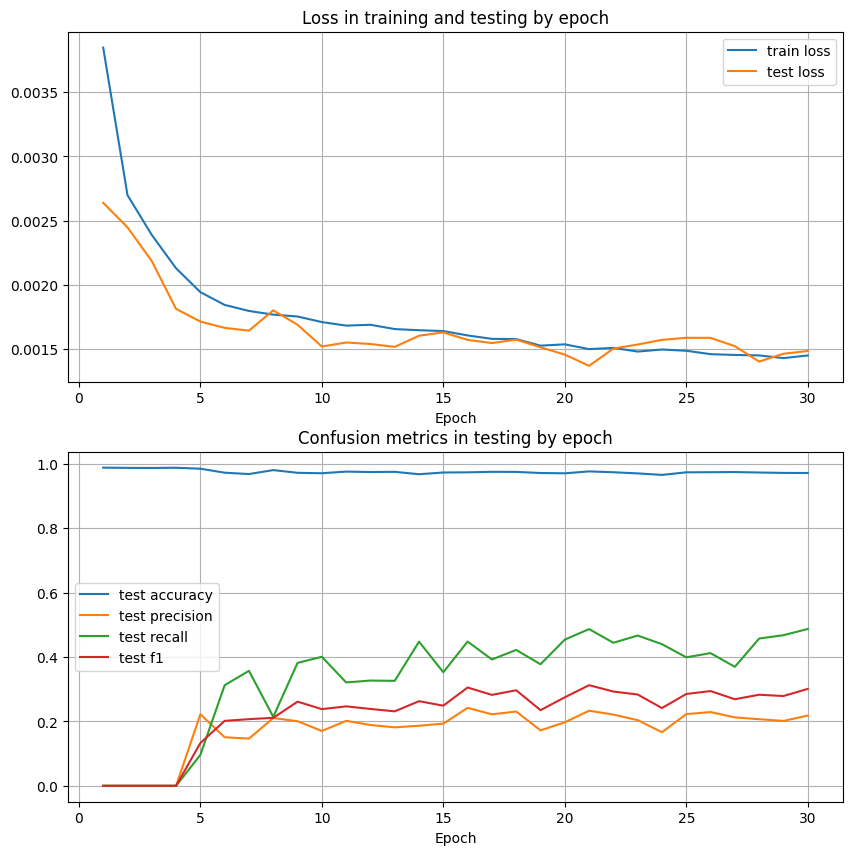

In [11]:


print(f"Training ends {datetime.now().isoformat()}")
for metric in ["accuracy", "precision", "recall", "f1", "mcc"]:
    if len(model_metrics[f"test_{metric}"]) > 0:
        print(f"Test {metric}:", model_metrics[f"test_{metric}"][-1])

plot_model_metrics(model_metrics)

In [12]:
os.makedirs(model_output_dir, exist_ok=True)
torch.save(model, f"{model_output_dir}/model.pickle")
torch.save({
    "train_slides": set(train_slides["slide_name"]),
    "test_slides": set(test_slides["slide_name"])
},
    f"{model_output_dir}/data-split.pickle"
)